In [1]:
import sys
import os
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:
def euc_dist(a, b):
    return np.linalg.norm(a - b, ord=2)

def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def norm_data(X):
    mean, std = X.mean(axis=0), X.std(axis=0)
    return (X - mean) / std, (mean, std)

def argsort(a):
    return np.array(a).argsort()

In [3]:
class kNearestNeighbor():
    def __init__(self, k=3, dist_metric='euclidean', norm=True):
        self.k = k
        self.isFit = False
        self.norm = norm
        self._set_dist_func(dist_metric)

    def fit(self, X_train, y_train, v=False):
        if self.norm:
            X_train, (trn_mean, trn_std) = norm_data(X_train)
            self.trn_mean = trn_mean
            self.trn_std = trn_std
        self.X_train = X_train
        self.y_train = y_train
        y_train_pred, y_train_pred_proba = [], []
        for i, x_i in enumerate(X_train):
            distances = []
            for j, x_j in enumerate(X_train):
                if i == j:
                    dist_ij = 0
                else:
                    dist_ij = self.dist_func(x_i, x_j)
                distances.append(dist_ij)
            pred_i = self.estimate_point(distances, y_train)
            y_train_pred_i, y_train_pred_proba_i = pred_i
            y_train_pred.append(y_train_pred_i)
            y_train_pred_proba.append(y_train_pred_proba_i)
        if v:
            trn_acc = accuracy(y_train, y_train_pred)
            print('training accuracy: {}'.format(trn_acc))
        self.isFit = True

    def estimate_point(self, distances, y):
        sort_idx = argsort(distances)
        y_closest = y[sort_idx][:self.k]
        most_common = Counter(y_closest).most_common(1)[0]
        y_pred_i = most_common[0]
        y_pred_proba_i = most_common[1] / len(y_closest)
        return y_pred_i, y_pred_proba_i

    def norm_new(self, X_new):
        return (X_new - self.trn_mean) / self.trn_std

    def predict(self, X_new):
        if not (self.isFit):
            raise Exception('run knn.fit(x_trn, y_trn) before running knn.predict(x_new)')
        if self.norm:
            X_new = self.norm_new(X_new)
        y_new_pred, y_new_pred_proba = [], []
        for i, x_i in enumerate(X_new):
            distances = []
            for j, x_j in enumerate(self.X_train):
                dist_ij = self.dist_func(x_i, x_j)
                distances.append(dist_ij)
            pred_i = self.estimate_point(distances, self.y_train)
            y_pred_i, y_pred_proba_i = pred_i
            y_new_pred.append(y_pred_i)
            y_new_pred_proba.append(y_pred_proba_i)
        return y_new_pred

    def _set_dist_func(self, dist_metric):
        implemented_metrics = {'euclidean': euc_dist, }
        try:
            self.dist_func = implemented_metrics[dist_metric]
        except KeyError:
            raise Exception('{} is not an acceptable argument for dist_metric'.format(dist_metric))

In [4]:
def scatter_plot(X, y, X_trn, y_trn, X_test, y_test, k, feature_idxs, knn, h=0.05):
    classes = list(set(y))
    cmap_light = ListedColormap(['#FFD0CF', '#D9FFD7', '#BBECEE'])
    colours = ['red', 'green', 'blue']
    pad = 0.5
    x_min, x_max = X[:, feature_idxs[0]].min() - pad, X[:, feature_idxs[0]].max() + pad
    y_min, y_max = X[:, feature_idxs[1]].min() - pad, X[:, feature_idxs[1]].max() + pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    for i in classes:
        idx = np.where(y_trn == classes[i])
        plt.scatter(X_trn[idx, 0],
                    X_trn[idx, 1],
                    c=colours[i],
                    label=legend[i],
                    marker='o', s=20)
    for i in classes:
        idx = np.where(y_test == classes[i])
        plt.scatter(X_test[idx, 0],
                    X_test[idx, 1],
                    c=colours[i],  # label=legend[i],
                    marker='x', s=20)
    plt.legend()
    plt.xlabel(xlbl, fontsize=16)
    plt.ylabel(ylbl, fontsize=16)
    plt.title("kNN classification (k = {}) - train (o), test (x)"
              .format(k), fontsize=16)
    plt.show()

In [5]:
# Cargar Dataset
iris = datasets.load_iris()
X = iris.data  
y = iris.target

# Con fines ilustrativos, solo usaremos las dos funciones del conjunto de datos.
feature_idxs = [1, 3]

feature_names = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
xlbl, ylbl = feature_names[feature_idxs[0]], feature_names[feature_idxs[1]] 
# También dividiremos el conjunto de datos en entrenamiento y prueba para poder evaluar el clasificador kNN.
X_trn_, X_test_, y_trn, y_test = train_test_split(X, 
                                                 y, 
                                                 test_size=0.333, 
                                                 random_state=0,
                                                 stratify=y)
X_trn, X_test = X_trn_[:, feature_idxs], X_test_[:, feature_idxs]

print("X_trn.shape = {}, X_test.shape = {}".format(X_trn.shape, X_test.shape))
print("Features: {}, {}".format(feature_names[feature_idxs[0]], feature_names[feature_idxs[1]]))

X_trn.shape = (100, 2), X_test.shape = (50, 2)
Features: Sepal Width, Petal Width


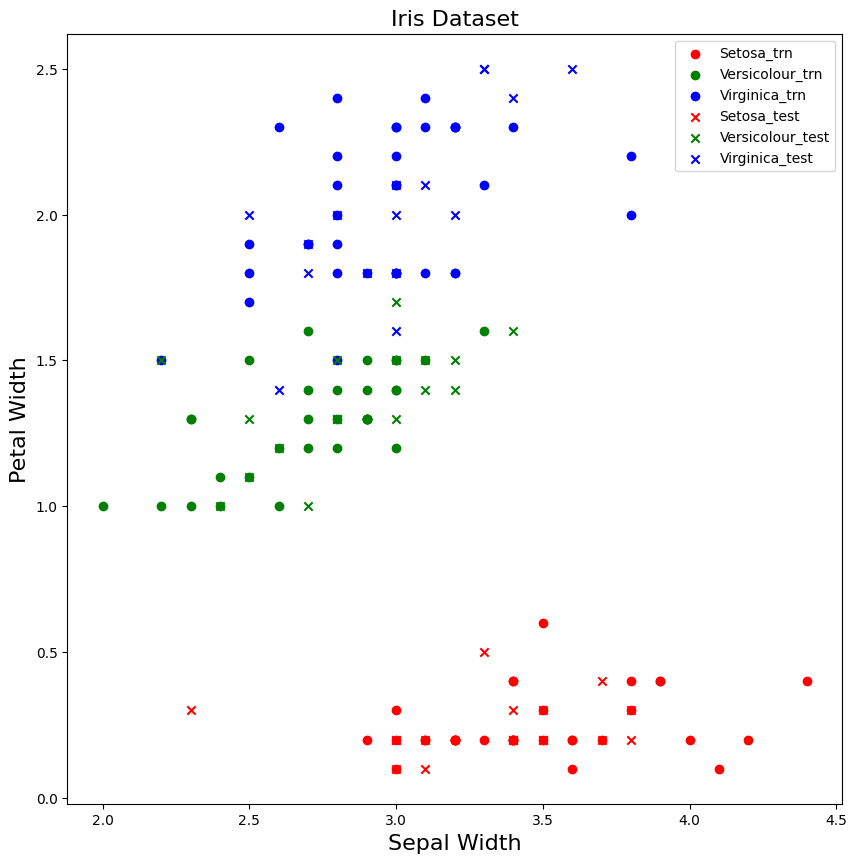

In [6]:
# Un diagrama de dispersión que muestra cada especie según la longitud del sépalo (eje x) y la longitud del sépalo (eje y)
colours = ['red', 'green', 'blue']
legend = ['Setosa', 'Versicolour', 'Virginica']
classes = list(set(y))
f = plt.figure(figsize=(10, 10))
for i in classes:
    idx = np.where(y_trn == classes[i])
    plt.scatter(X_trn[idx, 0], 
                X_trn[idx, 1], 
                c=colours[i], 
                label=legend[i] + '_trn')

for i in classes:
    idx = np.where(y_test == classes[i])
    plt.scatter(X_test[idx, 0], 
                X_test[idx, 1], 
                c=colours[i], 
                label=legend[i] + '_test',
                marker='x')
    
    
plt.legend()
plt.title('Iris Dataset', fontsize=16)
plt.xlabel(xlbl, fontsize=16)
plt.ylabel(ylbl, fontsize=16)
plt.show()

train accuracy: 0.97
test accuracy: 0.92


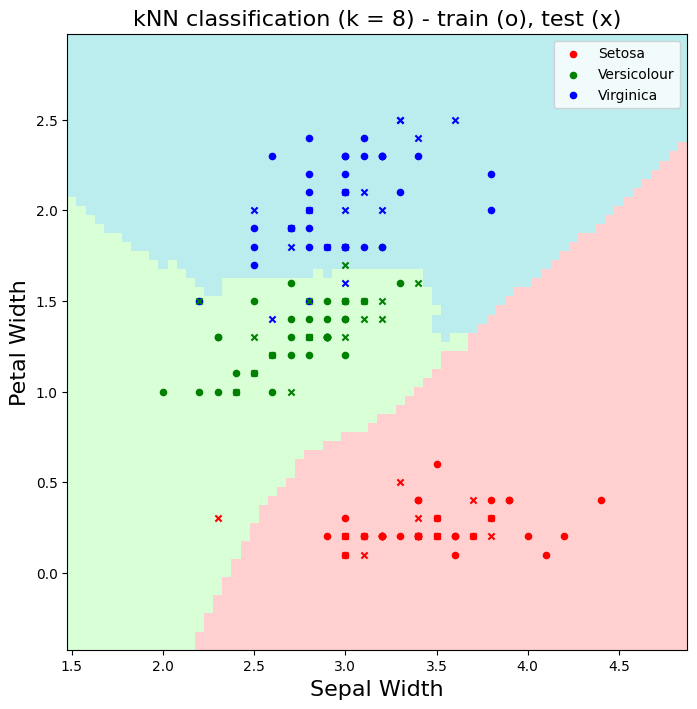

In [7]:
k = 8
knn = kNearestNeighbor(k=k)
knn.fit(X_trn, y_trn, v=False)
y_trn_pred = knn.predict(X_trn)
trn_acc = accuracy(y_trn_pred, y_trn)
y_test_pred = knn.predict(X_test)
test_acc = accuracy(y_test_pred, y_test)
print('train accuracy: {}'.format(trn_acc))
print('test accuracy: {}'.format(test_acc))

scatter_plot(X, y, X_trn, y_trn, X_test, y_test, k, feature_idxs, knn)

In [8]:
# Tune k
k_list, trn_accs_list, test_accs_list = [], [], []
for k in range(1, 20):
    knn = kNearestNeighbor(k=k)
    knn.fit(X_trn, y_trn, v=False)
    y_trn_pred = knn.predict(X_trn)
    trn_acc = accuracy(y_trn_pred, y_trn)
    y_test_pred = knn.predict(X_test)
    test_acc = accuracy(y_test_pred, y_test)
    k_list.append(k)
    trn_accs_list.append(trn_acc)
    test_accs_list.append(test_acc)

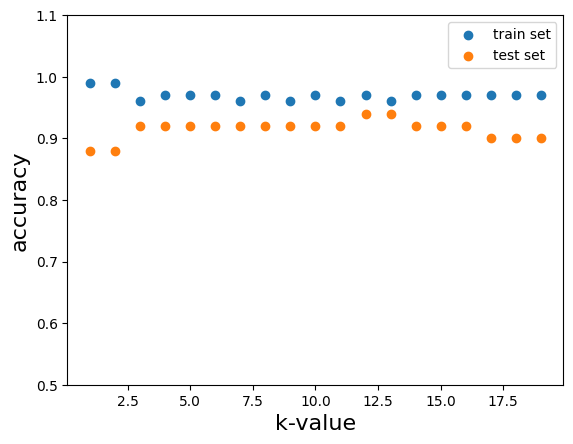

In [9]:
plt.scatter(k_list, trn_accs_list, label='train set')
plt.scatter(k_list, test_accs_list, label='test set')
plt.xlabel('k-value', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
plt.ylim([0.5, 1.1])
plt.legend()
plt.show()

optimal value for k: 12
train accuracy: 0.97
test accuracy: 0.94


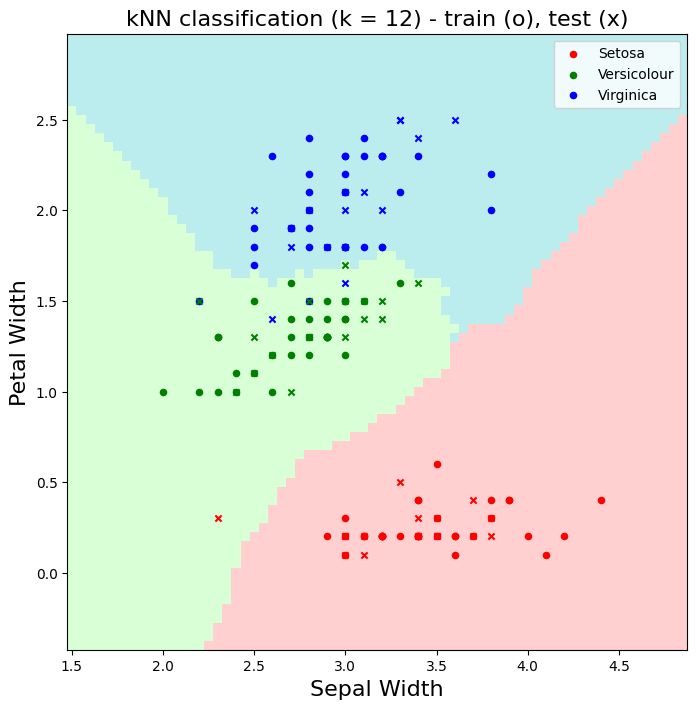

In [10]:
k = np.argmax(test_accs_list) + 1
print('optimal value for k: {}'.format(k))
knn = kNearestNeighbor(k=k)
knn.fit(X_trn, y_trn, v=False)
y_trn_pred = knn.predict(X_trn)
trn_acc = accuracy(y_trn_pred, y_trn)
y_test_pred = knn.predict(X_test)
test_acc = accuracy(y_test_pred, y_test)
print('train accuracy: {}'.format(trn_acc))
print('test accuracy: {}'.format(test_acc))

scatter_plot(X, y, X_trn, y_trn, X_test, y_test, k, feature_idxs, knn)

0 0
Features: Sepal Length, Sepal Length
	 train accuracy: 0.75
	 test accuracy: 0.74
0 1
Features: Sepal Width, Sepal Length
	 train accuracy: 0.85
	 test accuracy: 0.72
0 2
Features: Petal Length, Sepal Length
	 train accuracy: 0.93
	 test accuracy: 0.86
0 3
Features: Petal Width, Sepal Length
	 train accuracy: 0.97
	 test accuracy: 0.94
1 0
Features: Sepal Length, Sepal Width
	 train accuracy: 0.85
	 test accuracy: 0.72
1 1
Features: Sepal Width, Sepal Width
	 train accuracy: 0.67
	 test accuracy: 0.46
1 2
Features: Petal Length, Sepal Width
	 train accuracy: 0.93
	 test accuracy: 0.94
1 3
Features: Petal Width, Sepal Width
	 train accuracy: 0.97
	 test accuracy: 0.94
2 0
Features: Sepal Length, Petal Length
	 train accuracy: 0.93
	 test accuracy: 0.86
2 1
Features: Sepal Width, Petal Length
	 train accuracy: 0.93
	 test accuracy: 0.94
2 2
Features: Petal Length, Petal Length
	 train accuracy: 0.94
	 test accuracy: 0.98
2 3
Features: Petal Width, Petal Length
	 train accuracy: 0.96


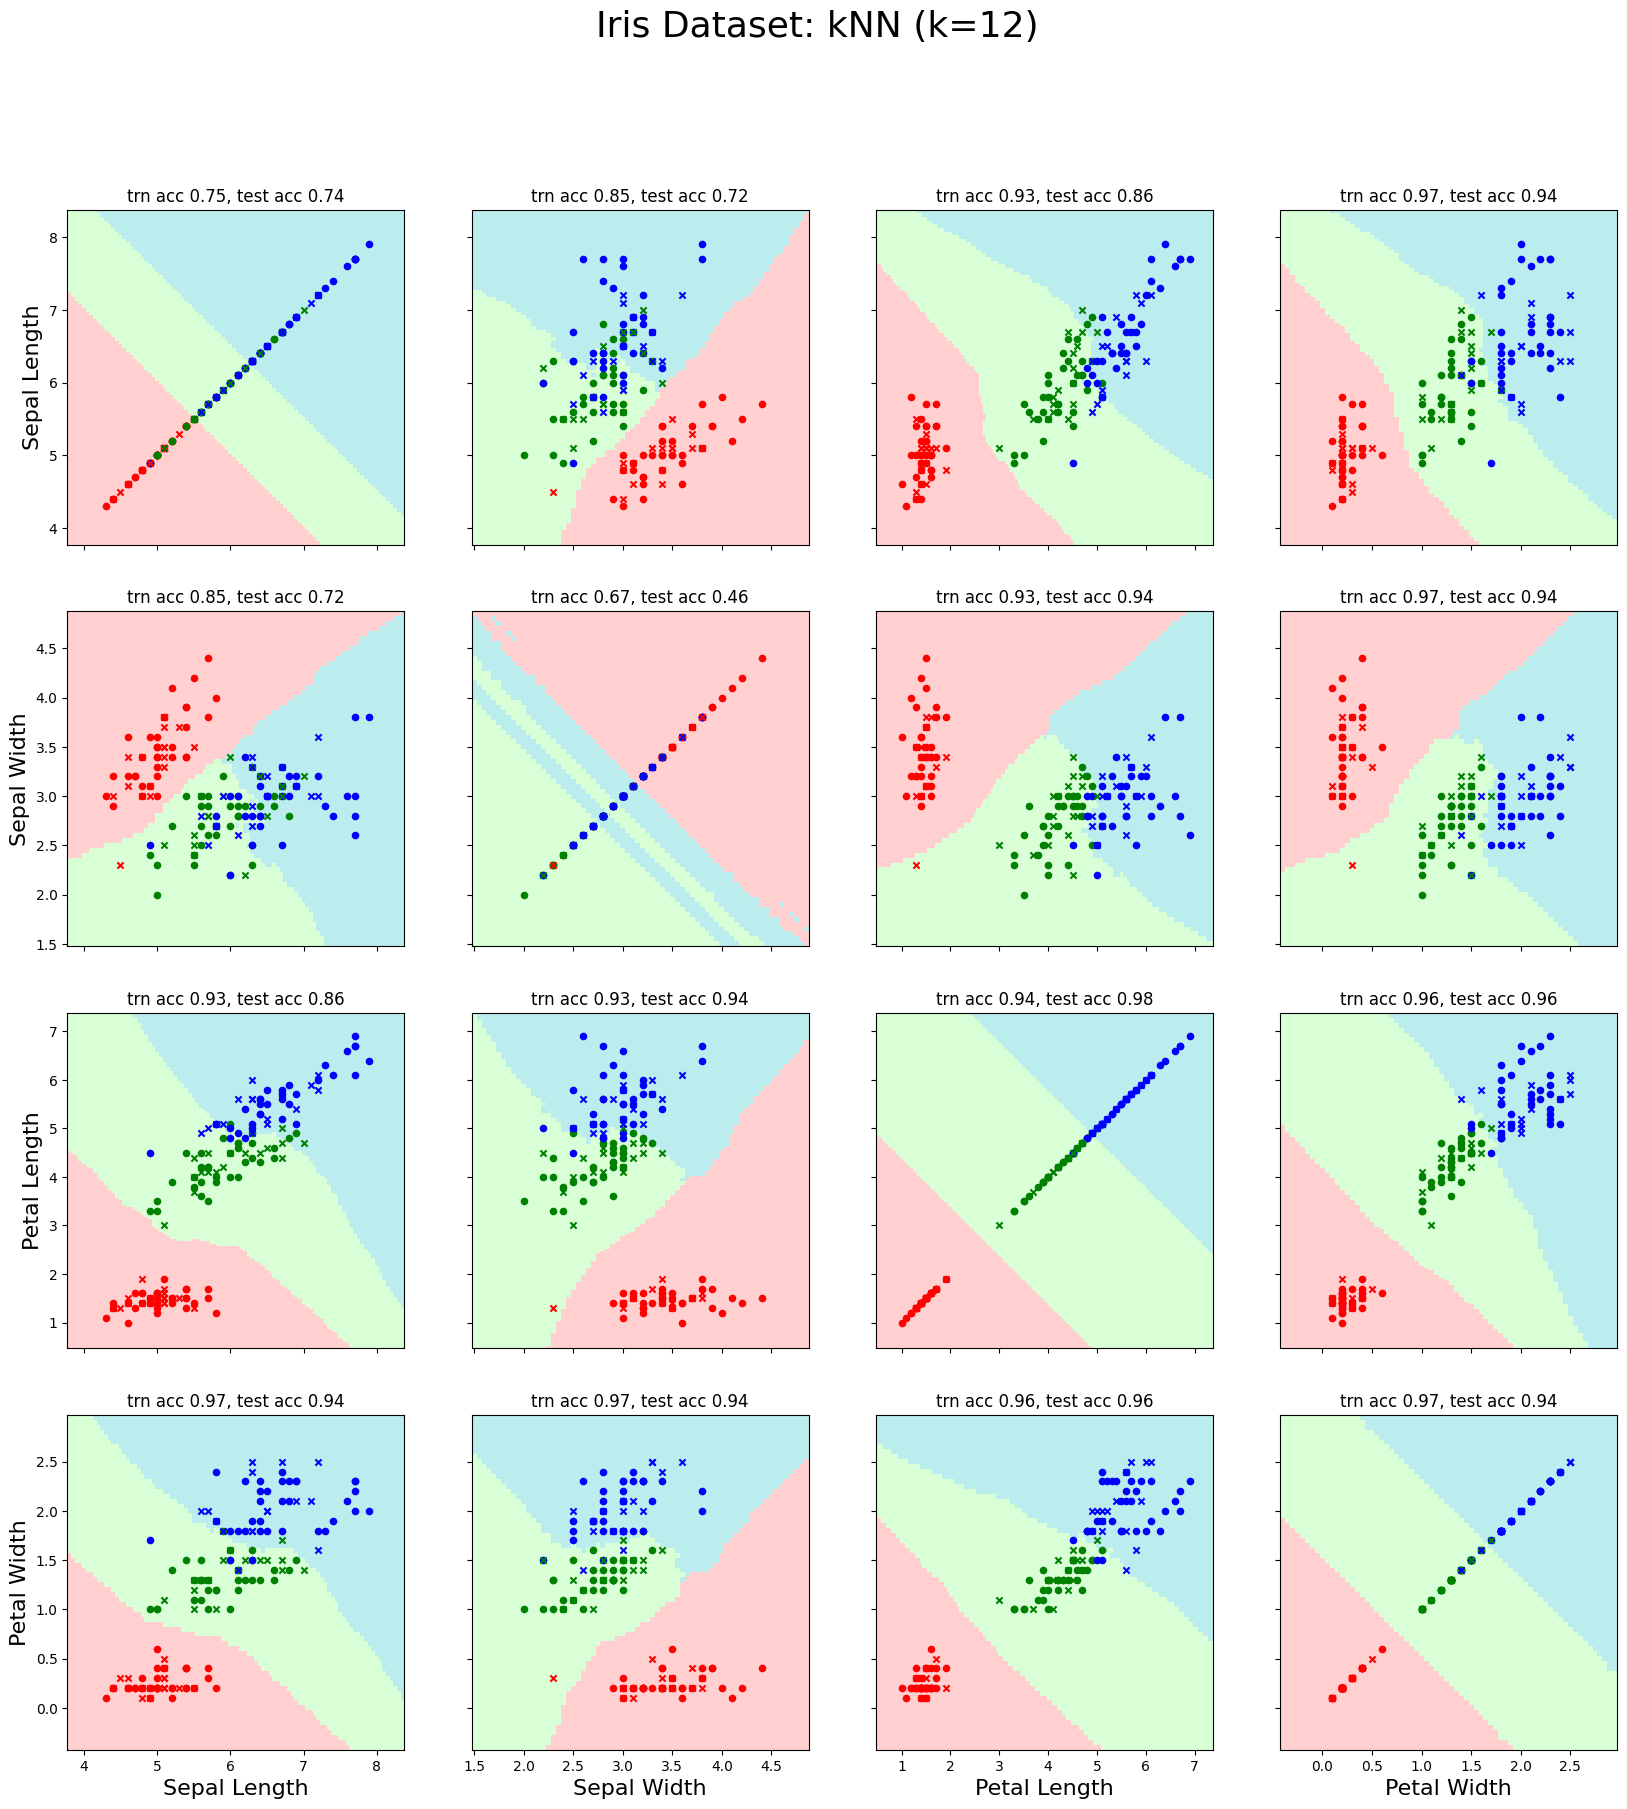

In [11]:
h = .05
pad = 0.5
cmap_light = ListedColormap(['#FFD0CF', '#D9FFD7', '#BBECEE'])
colours = ['red', 'green', 'blue']
fig, axs = plt.subplots(4, 4, figsize=(20, 20), sharex='col', sharey='row',)
n_features = X.shape[1]
for row in range(n_features):
    #for col in range(row):
    for col in range(n_features):
        
        print(row, col)
        feature_idxs = [col, row, ]
        xlbl, ylbl = feature_names[feature_idxs[0]], feature_names[feature_idxs[1]] 
        X_trn, X_test = X_trn_[:, feature_idxs], X_test_[:, feature_idxs]
        print("Features: {}, {}".format(feature_names[feature_idxs[0]], feature_names[feature_idxs[1]]))
        
        knn = kNearestNeighbor(k=k)
        knn.fit(X_trn, y_trn, v=False)
        y_trn_pred = knn.predict(X_trn)
        trn_acc = accuracy(y_trn_pred, y_trn)
        y_test_pred = knn.predict(X_test)
        test_acc = accuracy(y_test_pred, y_test)
        print('\t train accuracy: {}'.format(trn_acc))
        print('\t test accuracy: {}'.format(test_acc))
        
        x_min, x_max = X[:, feature_idxs[0]].min() - pad, X[:, feature_idxs[0]].max() + pad
        y_min, y_max = X[:, feature_idxs[1]].min() - pad, X[:, feature_idxs[1]].max() + pad
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = np.array(Z).reshape(xx.shape)
        axs[row, col].pcolormesh(xx, yy, Z, cmap=cmap_light)

        for i in classes:
            idx = np.where(y_trn == classes[i])
            axs[row, col].scatter(X_trn[idx, 0], 
                        X_trn[idx, 1], 
                        c=colours[i], 
                        label=legend[i],
                        marker='o', s=20)

        for i in classes:
            idx = np.where(y_test == classes[i])
            axs[row, col].scatter(X_test[idx, 0], 
                        X_test[idx, 1],
                        c=colours[i], 
                        marker='x', s=20)

        if row==n_features-1:
            axs[row, col].set_xlabel(xlbl, fontsize=16)
            
        if col==0:
            axs[row, col].set_ylabel(ylbl, fontsize=16)
        axs[row, col].set_title("trn acc {}, test acc {}".format(trn_acc, test_acc))
fig.suptitle('Iris Dataset: kNN (k={})'.format(k), fontsize=26)
plt.show()